# Modelling a phase stepping interferometer (PSI)

You will already be familiar with interferometry as a way of measuring the shape of test objects, perhaps lenses or mirrors, as they are being manufactured.  In general the interferometer produces a fringe pattern, but how do we make use of that fringe pattern to get quantitative data out on the shape of the test object?  You may already have thought about some of the problems with simply looking at the fringes and it basically comes down to how do you know which way a slope is going as both positive and negative slopes will give the same fringe pattern?  The answer to this simple problem is that you move either the test object or the reference mirror and you look at the direction in which the fringes move.  A fringe denotes a constant path difference and so as you move the test or reference you can track the path difference. Visually that works, but it still doesn’t get you a simple quantitative answer. 

## Phase stepping interferometry

What the concept of changing the interferometer path length does highlight is that you might be able to get a quantitative answer by moving, or phase stepping, the reference or test object.  To understand how this might work, start by considering the interference between a reference wave $E_R=A\exp⁡(i\phi_R)$ and a test wave $E_T=B\exp⁡(i\phi_T)$ to give an intensity $I(\phi_R,\phi_T)$:

$$\begin{aligned}
I(\phi_R,\phi_T)& =\left|E_R+E_T \right|^2\\
& =\left(A \exp⁡(i\phi_R )+B \exp⁡(i\phi_T ) \right)\times\left(A \exp⁡(-i\phi_R )+B \exp⁡(-i\phi_T )\right)\\
& =A^2+B^2+AB \exp⁡(i(\phi_T-\phi_R ))+AB \exp⁡(-i(\phi_T-\phi_R ))\\
& =A^2+B^2+2AB \cos⁡(\phi_T-\phi_R )
\end{aligned}$$

Mathematically we need to work out the phase difference, which appears in the sinusoidal interference term.  With 3 unknowns ($A$, $B$ and $(\phi_T-\phi_R)$), we need a minimum of 3 equations to do this, which we can get by adding 3 different phases to the reference and measuring the resulting intensity interference patterns for each. However, to make things slightly simpler for now let’s take 4 samples and step the phase of the reference between each interferogram by $\pi/2$:

$$\begin{aligned}
I_1=I(\phi_R,\phi_T )&=A^2+B^2+2AB \cos⁡(\phi_T-\phi_R )\\
I_2=I(\phi_R,\phi_T + \pi/2 )&=A^2+B^2+2AB \cos⁡(\phi_T-\phi_R-\pi/2) \\
& = A^2+B^2+2AB \sin(\phi_T-\phi_R)\\
I_3=I(\phi_R,\phi_T + \pi )&=A^2+B^2-2AB \cos⁡(\phi_T-\phi_R)\\
I_4=I(\phi_R,\phi_T +3\pi/2)&=A^2+B^2-2AB \sin⁡(\phi_T-\phi_R )\\
\end{aligned}$$

Then subtracting the intensities in pairs we get:

$$I_1-I_3=4AB \cos⁡(\phi_T-\phi_R )$$
$$I_2-I_4=4AB \sin⁡(\phi_T-\phi_R )$$

and the phase difference can be extracted by calculating:

$$\phi_T-\phi_R=\tan^{-1}⁡\left(\frac{I_2-I_4}{I_1-I_3}\right)$$

This is the basis of phase stepping interferometry, and in this instance with four images at four equally stepped phases this is known as the 4-bucket PSI algorithm.  Many different algorithms exist with various numbers of steps that each have their own advantages and disadvantages.  You might like to look up some others on the internet, or in the classic textbook [“Optical Shop Testing” by Daniel Malacara](https://library-search.imperial.ac.uk/permalink/44IMP_INST/f7tnsv/alma991000343771501591), in particular chapter 14.  The aim of this modelling experiments in to build a model of an interferometer that can be used to simulate a phase stepping interferometer and to assess the performance of different phase extraction algorithms. 

You will need to write code to build your computer model that will allow you to demonstrate and assess its performance.  As part of this you will need to simulate a set of recorded interferograms, apply the phase reconstruction algorithm, deal with unwrapping the phase that comes out of the arctangent and calculate some performance metrics on the result.  How you do this is described in the next section.  You should also then look at what happens if things go wrong: what happens if the phase steps are incorrect; how robust are the algorithms in the presence of noise; what if the camera has a non-linear response to intensity; etc.?

## Simulating the phase stepping interferometer

As you have already completed the “Introduction to modelling an interferometer” demonstration experiment then you should already be on the way to building the software tools that you will require.  You should look back at the script for that experiment to help you get started on this one.  In addition, this script goes through a number of steps to simulate a 3-step phase shifting interferometer that goes quite a long way to calculating the sort of things you will need to look at here.  The code here will run standalone in the Jupyter notebook, but you should aim to do better buy writing a set of functions or even some object oriented code so that you can plot graphs and compare different errors and algorithms!  Initially try to follow the steps below.

### Step 1: Set up some useful arrays

`N` is the size of array that you will be using and `mask` will let us work with circular apertures (as though you were measuring a circular optical element).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

N = 256 # array size to work on

# set up arrays and plot some simple figures
xg, yg = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
rg = np.sqrt(xg ** 2 + yg ** 2)
theta = np.arctan2(yg, xg)
mask = (rg <= 1)

### Step 2: Generate a random yet slowly varying test element phase

This code block also uses the `mask` to generate the data as a masked array and calculates some useful metrics on the resulting phase function.

Mean value 0.4055 rad, RMS value 2.1563 rad, Range 8.2912 rad


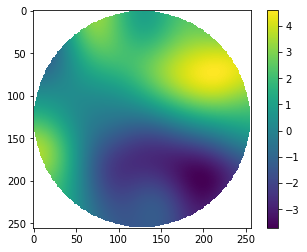

In [2]:
# create a random image with low spatial frequency content
ri = np.random.rand(N // 10, N // 10) - 0.5
kern = scipy.ndimage.zoom( np.exp(-rg ** 2 / (2 * 0.25 ** 2)), 0.1)
ro = scipy.signal.convolve2d(ri, kern, boundary='symm', mode='same')
ro_big = scipy.ndimage.zoom(ro, (N / ro.shape[0], N / ro.shape[1]))
phase = np.ma.masked_array(ro_big, ~mask)
plt.imshow(phase)
plt.colorbar()
print(f'Mean value {np.mean(phase):.4f} rad,', 
      f'RMS value {np.std(phase):.4f} rad,', 
      f'Range {(phase.max() - phase.min()):.4f} rad')
testwf = np.exp(1j * phase)

### Step 3: Calculate some interferograms
Calculate interferograms for a 3-step phase stepping interferometer.  Here we also define a tilted reference phase so that a number of pringes are visible.  It also introduces an error in the phase step as it is not exactly $2\pi/3$.

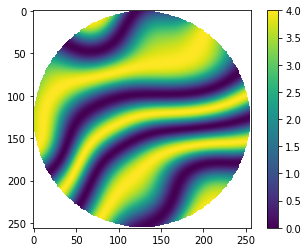

In [3]:
# 3 step PSI algorithm
pstep = 2.2 * np.pi / 3
refphase = 5 * xg + 8 * yg
I1 = np.abs(np.exp(1j * (refphase)) + testwf) ** 2
I2 = np.abs(np.exp(1j * (refphase + pstep)) + testwf) ** 2
I3 = np.abs(np.exp(1j * (refphase + 2 * pstep)) + testwf) ** 2
plt.figure()
plt.imshow(I1)
plt.colorbar()

### Step 4: Calculate the measured phase using the 3-bucket PSI algorithm
Note that the output phase is wrapped so that all values lie in the range $-\pi:\pi$.

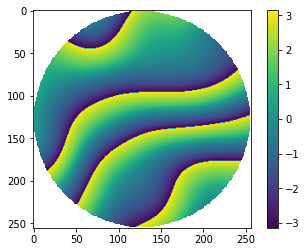

In [4]:
p = np.arctan2(np.sqrt(3) / 2 * (I2 - I3), (I1 - (I2 + I3) / 2))
plt.figure()
plt.imshow(p)
plt.colorbar()

### Step 5: Try to unwrap the phase by removing the $2\pi$ steps
We need to remove the $2\pi$ phase steps from the recovered phase and there is a `numpy` function `unwrap()` that does exactly that:

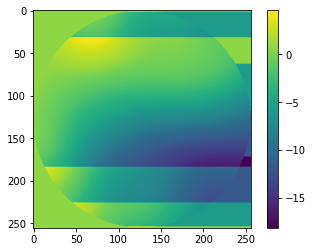

In [5]:
# try to unwrap the phase
plt.figure()
plt.imshow(np.unwrap(np.unwrap(p, axis=0), axis=1))
plt.colorbar()

However it does not work so well with two-dimensional data.  A solution is to unwrap the phase from the middle outwards:

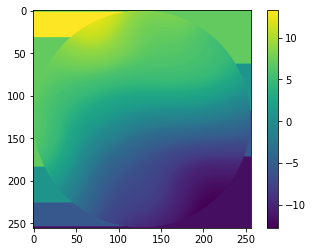

In [6]:
# try to unwrap phase from middle out half of image at a time
q = np.zeros_like(p)
q[N // 2:, :] = np.unwrap(p[N // 2:,:], axis=0)
q[N // 2::-1, :] = np.unwrap(p[N // 2::-1, :], axis=0)
q[:, N // 2:] = np.unwrap(q[:, N // 2:], axis=1)
q[:, N // 2::-1] = np.unwrap(q[:, N // 2::-1], axis=1)
plt.figure()
plt.imshow(q)
plt.colorbar()

### Step 6: Take off the reference phase to get our measured phase


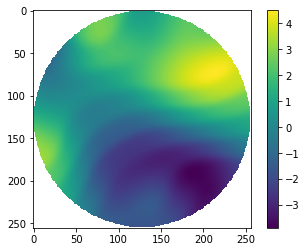

In [7]:
# take off tilt to see what is left
plt.figure()
measured_phase = np.ma.masked_array(q + refphase, ~mask)
plt.imshow(measured_phase)
plt.colorbar()

### Step 7: Assess the result
Ideally we should get back what we put in, which to a certain extent you can appreciate by comparing the figure above with the original phase plot from Step 2 where you should be able to see some artefacts appear, in particular fine ripples in the phase that are due to an incorrect phase step. However to make these artefacts clearer calculate the difference between the reconstructed output phase and the input phase as a resudual

To assess the performance of our 3-bucket PSI reconstruction, plot the residual and calculate some statistics on the result.  Note that an offset in the phase (the mean value) is not generally considered a problem, but the RMS variation about that offset is.

Mean value -0.2107 rad, RMS value 0.0913 rad, Range 0.2591 rad


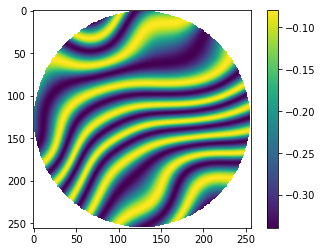

In [8]:
# take off aberration to see what is left
plt.figure()
residual = measured_phase - phase 
plt.imshow(residual)
plt.colorbar()
print(f'Mean value {np.mean(residual):.4f} rad,', 
      f'RMS value {np.std(residual):.4f} rad,', 
      f'Range {(residual.max() - residual.min()):.4f} rad')

## Analysing performance of a non-ideal phase shifting interferometer 

Your model so far has essentially described a PSI with one type of error (incorrect phase step) and one type of reconstruction (3-bucket).  You could imagine a number of things going wrong in a real system such as:

* The phase shifts in the reference are not correct.
* The intensity of the laser changes between images that you collect for the different interferograms.
* The camera has a non-linear response to intensity (look up gamma factor).
* The camera produces noise on the captured images e.g. additive read-out noise and/or fundamental shot noise.
* There are thermal air currents in the system that introduce an extra variable phase.

You now have the tools to examine all of these phenomena and the effect that they can have on your final extracted phase.  Start by looking at the sort of effects that each produces and try to assess their significance.  You should write you model as a function where the input might be the size of the "error" and the output is the metric that you observe, such as RMS value and/or range.  You can then investigate how the metric varies with the magnitude of the error.

<div class="alert alert-block alert-success"> Add your own input here. </div>

### Other PSI algorithms

It was mentioned above that there are many PSI algorithms in addition to the 4-bucket one shown in the introduction and the 3-bucket one in the previous section.  Some of these other algorithms are specifically designed to overcome some of the issues highlighted above.  Can you demonstrate that this is the case?  Are there any drawbacks to using these more complex algorithms?  Again Malacara’s book, particularly chapter 14 of the 3rd edition, will be helpful here.  You can find it and the 2nd edition in the central library or view or download an time restricted pdf copy of the 3rd edition via the central library website. 

<div class="alert alert-block alert-success"> Add your own input here. </div>

### Your report

The power of a computer model is that you can produce results for a range of test scenarios very quickly.  Do not be tempted to simply churn out images of extracted phases and fill your report with those.  By all means fill your lab bookm (or this notebook) with results from your model, but your report should be a more critical/analytical document that shows something useful.  Your report should include:

•	A description of your model including a demonstration of its phase reconstruction and analysis of any inaccuracies in the results that your model produces.
•	A demonstration and analysis of the inaccuracies that result from the sort of physical problems that can arise in a real interferometer (like those listed above).
•	A demonstration of one or more, more sophisticated algorithms that can mitigate the sort of effects you have just shown above.

<div class="alert alert-block alert-success"> Add your own input here. </div>